In [112]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

#LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#PCA
from sklearn.decomposition import PCA


In [113]:
import psycopg2
import os
from dotenv import load_dotenv
load_dotenv()

try:
    conn = psycopg2.connect(
        dbname=os.getenv('dbname'),
        user=os.getenv('user'),
        password=os.getenv('password'),
        host=os.getenv('host'),
        port=os.getenv('port')
    )
    print("Connection OK\n")
except Exception as e:
    print("Error:", e)

query = "SELECT * FROM combined_indicators;"
df_all = pd.read_sql(query, conn)
df_all['ind_code'] = df_all['ind_code'].str.strip()

df = df_all.pivot_table(
    index='date_month',
    columns='ind_code',
    values='value'
).reset_index()

df['date_month'] = pd.to_datetime(df['date_month'])
df = df.set_index('date_month')
df = df.asfreq('MS')

test_size = 18
train_data = df[:-test_size]
test_data = df[-test_size:]

print("Train:", train_data.shape)
print("Test :", test_data.shape)


Connection OK



C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\2982564361.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_all = pd.read_sql(query, conn)


Train: (204, 10)
Test : (18, 10)


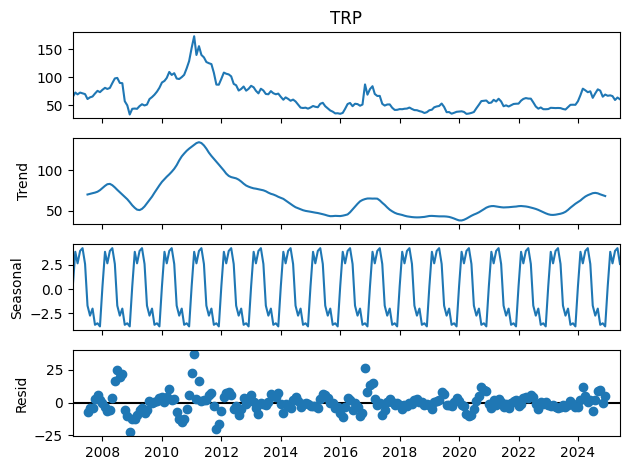

In [114]:
result = seasonal_decompose(df['TRP'], model='additive', period=12)
result.plot()
plt.show()

Available columns: ['EXR', 'OILP', 'PMI', 'TDC', 'TRI', 'TRP', 'TRPD', 'TRS', 'TRX', 'WRP']
Selected external factors: ['EXR', 'OILP', 'PMI', 'TDC', 'TRI', 'TRPD', 'TRS', 'TRX', 'WRP']

Mean TRP (train): 64.5769
X_train: (204, 9)  X_test: (18, 9)


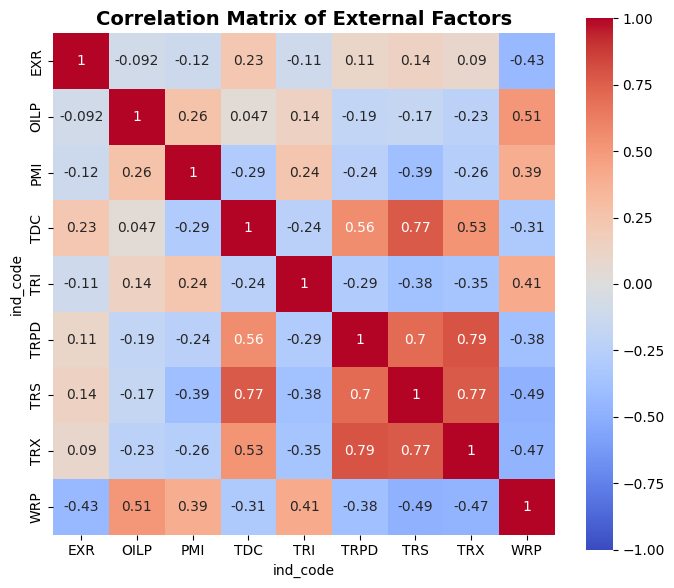

In [115]:
external_factors = ['EXR', 'OILP', 'PMI','TDC', 'TRI', 'TRPD','TRS', 'TRX', 'WRP']

print("Available columns:", df.columns.tolist())
print("Selected external factors:", [c for c in external_factors if c in df.columns])
print()

#เตรียม X, y
train_exog = train_data[external_factors].copy()
test_exog  = test_data[external_factors].copy()

X_train_raw = train_exog.copy()
X_test_raw  = test_exog.copy()
y_train = train_data['TRP']
y_test  = test_data['TRP']

mean_trp = y_train.mean()
print(f"Mean TRP (train): {mean_trp:.4f}")
print("X_train:", X_train_raw.shape, " X_test:", X_test_raw.shape)

# Scaling (ใช้กับทุกโมเดล Ridge)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test  = scaler.transform(X_test_raw)

# Correlation matrix ของ external factors
corr = train_exog.corr()

plt.figure(figsize=(7, 6))
sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    square=True
)
plt.title("Correlation Matrix of External Factors", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [116]:
full_train = train_data[['TRP'] + external_factors].copy()
full_test  = test_data[['TRP'] + external_factors].copy()

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(full_train)
test_scaled  = scaler.transform(full_test)

WINDOW = 12

def create_seq(data, win=WINDOW):
    X, y = [], []
    for i in range(len(data)-win):
        X.append(data[i:i+win, :])
        y.append(data[i+win, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_seq(train_scaled)
X_test, y_test   = create_seq(test_scaled)

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)


X_train: (192, 12, 10)
X_test : (6, 12, 10)


In [117]:
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=False,
         input_shape=(WINDOW, X_train.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_422"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_422 (LSTM)                 │ (None, 64)             │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_422 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_844 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_845 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,313 (83.25 KB)

 Trainable params: 21,313 (83.25 KB)

 Non-trainable params: 0 (0.00 B)

In [118]:
es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=16,
    callbacks=[es],
    verbose=1
)


Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0677 - val_loss: 0.0632
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0206 - val_loss: 0.0011
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0132 - val_loss: 9.5614e-04
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0123 - val_loss: 8.9834e-04
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0111 - val_loss: 0.0011
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0091 - val_loss: 7.4611e-04
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0087 - val_loss: 6.6001e-04
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0085 - val_loss: 0.0025
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - val_loss: 0.0011
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0086 - val_loss: 8.3624e-04
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0063 - val_loss: 0.0013
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s

In [135]:
pred_scaled = model.predict(X_test)

dummy = np.zeros((len(pred_scaled), train_scaled.shape[1]))
dummy[:,0] = pred_scaled[:,0]

pred = scaler.inverse_transform(dummy)[:,0]
actual = test_data['TRP'].iloc[WINDOW:].values

rmse_before = np.sqrt(mean_squared_error(actual, pred))
mape_before = mean_absolute_percentage_error(actual, pred)*100

print("=== BEFORE MODEL (Baseline LSTM) ===")
print(f"RMSE : {rmse_before:.4f}")
print(f"MAPE : {mape_before:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
=== BEFORE MODEL (Baseline LSTM) ===
RMSE : 13.6542
MAPE : 20.93%


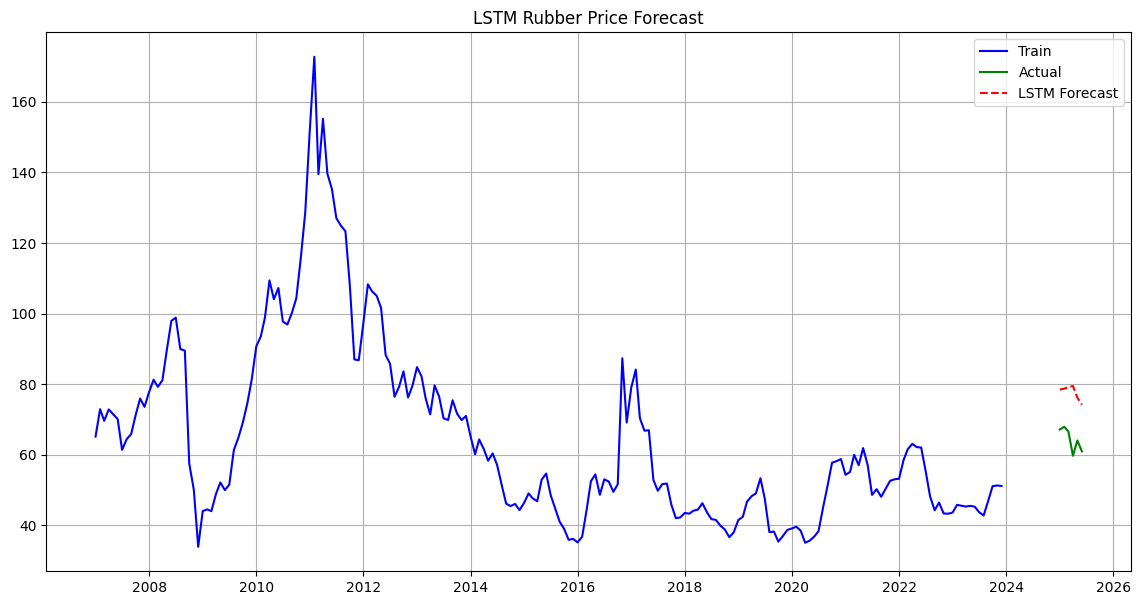

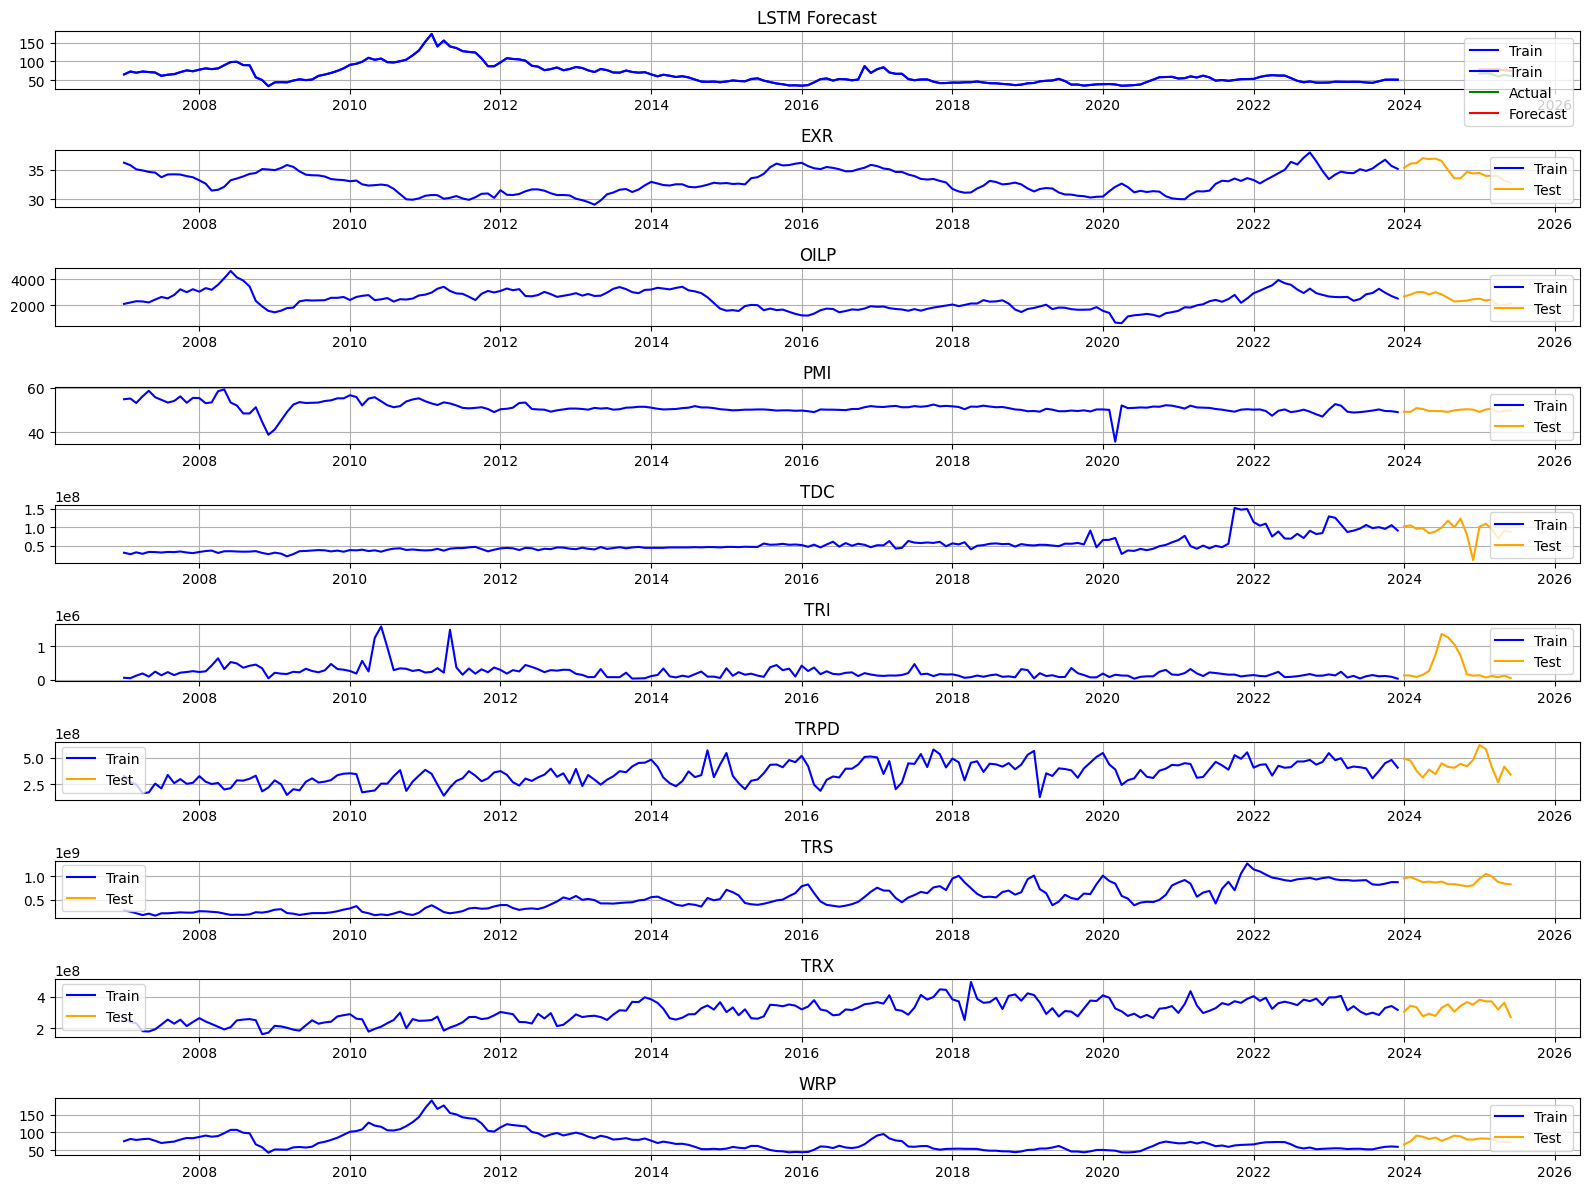

In [161]:
plt.figure(figsize=(14,7))
plt.plot(train_data.index, train_data['TRP'], label='Train', color='blue')
plt.plot(test_data.index[WINDOW:], actual, label='Actual', color='green')
plt.plot(test_data.index[WINDOW:], pred, label='LSTM Forecast', color='red', linestyle='--')
plt.title("LSTM Rubber Price Forecast")
plt.grid(True)
plt.legend()
plt.show()

fig, axes = plt.subplots(len(external_factors)+1, 1, figsize=(16,12))

axes[0].plot(train_data.index, train_data['TRP'], label='Train', color='blue')
axes[0].plot(train_data.index, train_data['TRP'], label='Train', color='blue')
axes[0].plot(test_data.index[WINDOW:], actual, color='green', label='Actual')
axes[0].plot(test_data.index[WINDOW:], pred, color='red', label='Forecast')
axes[0].legend()
axes[0].set_title("LSTM Forecast")
axes[0].grid(True)

for i, fac in enumerate(external_factors):
    ax = axes[i+1]
    ax.plot(train_data.index, train_data[fac], color='blue', label='Train')
    ax.plot(test_data.index, test_data[fac], color='orange', label='Test')
    ax.set_title(fac)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


Parameter Optimization (Optuna)

In [122]:
import optuna

def objective_lstm(trial):
    lstm_units = trial.suggest_int('lstm_units', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    dense_units = trial.suggest_int('dense_units', 16, 64)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)

    model = Sequential([
        LSTM(lstm_units, 
             activation='tanh', 
             return_sequences=False,
             input_shape=(WINDOW, X_train.shape[2])
            ),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=100,
        batch_size=16,
        callbacks=[es],
        verbose=0
    )

    pred_scaled = model.predict(X_test)
    dummy = np.zeros((len(pred_scaled), train_scaled.shape[1]))
    dummy[:,0] = pred_scaled[:,0]
    pred = scaler.inverse_transform(dummy)[:,0]
    actual = test_data['TRP'].iloc[WINDOW:].values

    rmse = np.sqrt(mean_squared_error(actual, pred))
    return rmse


study_lstm = optuna.create_study(direction='minimize')
study_lstm.optimize(objective_lstm, n_trials=60)

best_lstm_params = study_lstm.best_params
print("\n=== OPTUNA BEST PARAMS (LSTM) ===")
print(best_lstm_params)

[I 2025-11-25 18:10:09,997] A new study created in memory with name: no-name-6839951b-76a7-4dfc-9df5-062577d0f672
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


[I 2025-11-25 18:10:13,618] Trial 0 finished with value: 2.5484714058695537 and parameters: {'lstm_units': 76, 'dropout_rate': 0.45406183005137635, 'dense_units': 64, 'learning_rate': 0.007771890941644327}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


[I 2025-11-25 18:10:16,635] Trial 1 finished with value: 2.755513170079929 and parameters: {'lstm_units': 62, 'dropout_rate': 0.18266975595479826, 'dense_units': 29, 'learning_rate': 0.0003928061986026629}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


[I 2025-11-25 18:10:19,563] Trial 2 finished with value: 9.00704522754682 and parameters: {'lstm_units': 44, 'dropout_rate': 0.4394664506565614, 'dense_units': 50, 'learning_rate': 0.00019522995095992772}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


[I 2025-11-25 18:10:24,364] Trial 3 finished with value: 3.637440727170869 and parameters: {'lstm_units': 89, 'dropout_rate': 0.2178997107730659, 'dense_units': 36, 'learning_rate': 0.005766053192795925}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


[I 2025-11-25 18:10:27,433] Trial 4 finished with value: 12.190656284236793 and parameters: {'lstm_units': 88, 'dropout_rate': 0.498911580753726, 'dense_units': 39, 'learning_rate': 0.00017762192945697117}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


[I 2025-11-25 18:10:32,313] Trial 5 finished with value: 2.835502358895984 and parameters: {'lstm_units': 36, 'dropout_rate': 0.21268443159381173, 'dense_units': 34, 'learning_rate': 0.0018758084120906527}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


[I 2025-11-25 18:10:35,197] Trial 6 finished with value: 18.110723609533757 and parameters: {'lstm_units': 47, 'dropout_rate': 0.25995223010397184, 'dense_units': 36, 'learning_rate': 0.00012057448562908057}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


[I 2025-11-25 18:10:38,680] Trial 7 finished with value: 4.111650937350028 and parameters: {'lstm_units': 80, 'dropout_rate': 0.1643670140249578, 'dense_units': 28, 'learning_rate': 0.0019004552004912932}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


[I 2025-11-25 18:10:42,729] Trial 8 finished with value: 3.192759536081744 and parameters: {'lstm_units': 80, 'dropout_rate': 0.34952159003535305, 'dense_units': 20, 'learning_rate': 0.000248953354885476}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


[I 2025-11-25 18:10:46,812] Trial 9 finished with value: 4.411364790196906 and parameters: {'lstm_units': 108, 'dropout_rate': 0.31805345253437445, 'dense_units': 54, 'learning_rate': 0.0002898617794017015}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


[I 2025-11-25 18:10:52,012] Trial 10 finished with value: 13.376783223864265 and parameters: {'lstm_units': 124, 'dropout_rate': 0.37828981427070035, 'dense_units': 61, 'learning_rate': 0.009949148266457819}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


[I 2025-11-25 18:10:55,045] Trial 11 finished with value: 12.245727268275749 and parameters: {'lstm_units': 69, 'dropout_rate': 0.12396154352459124, 'dense_units': 18, 'learning_rate': 0.0006523081502396835}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


[I 2025-11-25 18:11:00,089] Trial 12 finished with value: 10.409113388302647 and parameters: {'lstm_units': 60, 'dropout_rate': 0.4151357829711941, 'dense_units': 47, 'learning_rate': 0.0006510086838383671}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


[I 2025-11-25 18:11:03,978] Trial 13 finished with value: 15.572764405284682 and parameters: {'lstm_units': 59, 'dropout_rate': 0.27314468843971057, 'dense_units': 62, 'learning_rate': 0.003485693097454861}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


[I 2025-11-25 18:11:06,878] Trial 14 finished with value: 2.8156766025253264 and parameters: {'lstm_units': 67, 'dropout_rate': 0.48987858113506644, 'dense_units': 27, 'learning_rate': 0.0005122204428590212}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


[I 2025-11-25 18:11:10,644] Trial 15 finished with value: 2.5554813377113788 and parameters: {'lstm_units': 102, 'dropout_rate': 0.13103567912067798, 'dense_units': 46, 'learning_rate': 0.001400217532587059}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


[I 2025-11-25 18:11:14,812] Trial 16 finished with value: 5.412770787032163 and parameters: {'lstm_units': 103, 'dropout_rate': 0.10494136224981176, 'dense_units': 46, 'learning_rate': 0.0016046317278959415}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


[I 2025-11-25 18:11:18,760] Trial 17 finished with value: 7.909848808865444 and parameters: {'lstm_units': 105, 'dropout_rate': 0.4358138570713191, 'dense_units': 56, 'learning_rate': 0.0036898989377081005}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


[I 2025-11-25 18:11:23,403] Trial 18 finished with value: 5.338470782229182 and parameters: {'lstm_units': 120, 'dropout_rate': 0.30866536894292373, 'dense_units': 43, 'learning_rate': 0.009026639634457871}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


[I 2025-11-25 18:11:29,718] Trial 19 finished with value: 10.87362268527956 and parameters: {'lstm_units': 97, 'dropout_rate': 0.3799936073076756, 'dense_units': 64, 'learning_rate': 0.0010262779747994772}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


[I 2025-11-25 18:11:36,382] Trial 20 finished with value: 4.409574799500157 and parameters: {'lstm_units': 117, 'dropout_rate': 0.2583227300376819, 'dense_units': 56, 'learning_rate': 0.003985043007714339}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


[I 2025-11-25 18:11:39,833] Trial 21 finished with value: 9.926261221443793 and parameters: {'lstm_units': 70, 'dropout_rate': 0.15009755707028166, 'dense_units': 27, 'learning_rate': 0.00036291945855634737}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


[I 2025-11-25 18:11:44,989] Trial 22 finished with value: 3.0502857920724304 and parameters: {'lstm_units': 54, 'dropout_rate': 0.198072819247057, 'dense_units': 31, 'learning_rate': 0.0010531987295462602}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


[I 2025-11-25 18:11:50,476] Trial 23 finished with value: 5.035560048407972 and parameters: {'lstm_units': 88, 'dropout_rate': 0.176572932884624, 'dense_units': 24, 'learning_rate': 0.0005188000011963387}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


[I 2025-11-25 18:11:54,043] Trial 24 finished with value: 8.197436653255146 and parameters: {'lstm_units': 75, 'dropout_rate': 0.1464717110112459, 'dense_units': 51, 'learning_rate': 0.002566591713331814}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


[I 2025-11-25 18:11:59,471] Trial 25 finished with value: 3.4554341638333494 and parameters: {'lstm_units': 99, 'dropout_rate': 0.10970171928709554, 'dense_units': 41, 'learning_rate': 0.00011678627751740686}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


[I 2025-11-25 18:12:04,825] Trial 26 finished with value: 8.515111007089788 and parameters: {'lstm_units': 91, 'dropout_rate': 0.232714062017169, 'dense_units': 22, 'learning_rate': 0.00569458988443462}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


[I 2025-11-25 18:12:12,111] Trial 27 finished with value: 12.846487393044859 and parameters: {'lstm_units': 113, 'dropout_rate': 0.19380495127495712, 'dense_units': 16, 'learning_rate': 0.001468925363564359}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


[I 2025-11-25 18:12:18,278] Trial 28 finished with value: 9.018027631999386 and parameters: {'lstm_units': 61, 'dropout_rate': 0.13135184991242807, 'dense_units': 59, 'learning_rate': 0.00037417858020260045}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


[I 2025-11-25 18:12:21,373] Trial 29 finished with value: 8.504578293202728 and parameters: {'lstm_units': 50, 'dropout_rate': 0.45622728666181545, 'dense_units': 50, 'learning_rate': 0.00018759419430441427}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


[I 2025-11-25 18:12:24,527] Trial 30 finished with value: 4.360568291490163 and parameters: {'lstm_units': 40, 'dropout_rate': 0.3400098589249415, 'dense_units': 32, 'learning_rate': 0.0007668781802686078}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


[I 2025-11-25 18:12:27,375] Trial 31 finished with value: 2.9842211767702977 and parameters: {'lstm_units': 69, 'dropout_rate': 0.4875464467415129, 'dense_units': 31, 'learning_rate': 0.000467603456517297}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


[I 2025-11-25 18:12:30,057] Trial 32 finished with value: 4.332496100662394 and parameters: {'lstm_units': 75, 'dropout_rate': 0.46888214243837567, 'dense_units': 26, 'learning_rate': 0.0007599658611116307}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


[I 2025-11-25 18:12:33,857] Trial 33 finished with value: 2.591681001095922 and parameters: {'lstm_units': 66, 'dropout_rate': 0.4158667694307643, 'dense_units': 39, 'learning_rate': 0.006696678671980646}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


[I 2025-11-25 18:12:41,268] Trial 34 finished with value: 4.631667689223075 and parameters: {'lstm_units': 78, 'dropout_rate': 0.3973571062495701, 'dense_units': 36, 'learning_rate': 0.006616258713750936}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


[I 2025-11-25 18:12:47,998] Trial 35 finished with value: 4.79963661372418 and parameters: {'lstm_units': 87, 'dropout_rate': 0.446447801644487, 'dense_units': 39, 'learning_rate': 0.006234824524846985}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


[I 2025-11-25 18:12:53,827] Trial 36 finished with value: 8.25737377067851 and parameters: {'lstm_units': 54, 'dropout_rate': 0.4211183372693754, 'dense_units': 43, 'learning_rate': 0.002711537338673846}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


[I 2025-11-25 18:12:59,958] Trial 37 finished with value: 3.5778347872686944 and parameters: {'lstm_units': 63, 'dropout_rate': 0.22050337353327287, 'dense_units': 36, 'learning_rate': 0.007544136313501667}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


[I 2025-11-25 18:13:04,555] Trial 38 finished with value: 4.601748955925414 and parameters: {'lstm_units': 33, 'dropout_rate': 0.1772625112826776, 'dense_units': 48, 'learning_rate': 0.004880478872787196}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


[I 2025-11-25 18:13:09,008] Trial 39 finished with value: 2.8056044448498287 and parameters: {'lstm_units': 83, 'dropout_rate': 0.33773369342118054, 'dense_units': 43, 'learning_rate': 0.00474159488781098}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


[I 2025-11-25 18:13:12,342] Trial 40 finished with value: 6.529211688855253 and parameters: {'lstm_units': 47, 'dropout_rate': 0.24806432004830825, 'dense_units': 52, 'learning_rate': 0.00015132555550256144}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


[I 2025-11-25 18:13:15,222] Trial 41 finished with value: 5.463210524449496 and parameters: {'lstm_units': 83, 'dropout_rate': 0.3572402433482706, 'dense_units': 44, 'learning_rate': 0.004774330113871394}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


[I 2025-11-25 18:13:21,306] Trial 42 finished with value: 6.165041123906093 and parameters: {'lstm_units': 96, 'dropout_rate': 0.2816432001335518, 'dense_units': 40, 'learning_rate': 0.0026269072567454157}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


[I 2025-11-25 18:13:25,239] Trial 43 finished with value: 2.625655478649188 and parameters: {'lstm_units': 73, 'dropout_rate': 0.40580570305628394, 'dense_units': 34, 'learning_rate': 0.00838701298435611}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


[I 2025-11-25 18:13:30,755] Trial 44 finished with value: 6.193449737622195 and parameters: {'lstm_units': 74, 'dropout_rate': 0.411942192787776, 'dense_units': 34, 'learning_rate': 0.008132548176974772}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


[I 2025-11-25 18:13:35,804] Trial 45 finished with value: 7.512606999148027 and parameters: {'lstm_units': 56, 'dropout_rate': 0.36771601298345563, 'dense_units': 30, 'learning_rate': 0.00722562216372486}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


[I 2025-11-25 18:13:40,072] Trial 46 finished with value: 8.844159693547454 and parameters: {'lstm_units': 65, 'dropout_rate': 0.4319630579796647, 'dense_units': 37, 'learning_rate': 0.00023145290433970527}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


[I 2025-11-25 18:13:48,021] Trial 47 finished with value: 4.556329865785186 and parameters: {'lstm_units': 73, 'dropout_rate': 0.3948981695884523, 'dense_units': 34, 'learning_rate': 0.009727170621844625}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


[I 2025-11-25 18:13:54,369] Trial 48 finished with value: 4.282369838499291 and parameters: {'lstm_units': 82, 'dropout_rate': 0.4747167223417268, 'dense_units': 37, 'learning_rate': 0.001394046479042033}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


[I 2025-11-25 18:14:01,666] Trial 49 finished with value: 3.494155090776446 and parameters: {'lstm_units': 92, 'dropout_rate': 0.39628675475553066, 'dense_units': 29, 'learning_rate': 0.0019077311566984023}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


[I 2025-11-25 18:14:09,249] Trial 50 finished with value: 3.619740265673689 and parameters: {'lstm_units': 126, 'dropout_rate': 0.4503394580821289, 'dense_units': 33, 'learning_rate': 0.0032364816221223495}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


[I 2025-11-25 18:14:19,155] Trial 51 finished with value: 4.327141484617771 and parameters: {'lstm_units': 85, 'dropout_rate': 0.3367045863700599, 'dense_units': 45, 'learning_rate': 0.00561651201044041}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


[I 2025-11-25 18:14:26,387] Trial 52 finished with value: 4.927517960484563 and parameters: {'lstm_units': 79, 'dropout_rate': 0.31546543858971826, 'dense_units': 42, 'learning_rate': 0.005186801306086543}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


[I 2025-11-25 18:14:31,085] Trial 53 finished with value: 6.001217732167526 and parameters: {'lstm_units': 66, 'dropout_rate': 0.29723660205599867, 'dense_units': 48, 'learning_rate': 0.008135201004628084}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


[I 2025-11-25 18:14:36,871] Trial 54 finished with value: 10.989834078071153 and parameters: {'lstm_units': 71, 'dropout_rate': 0.3807450276133025, 'dense_units': 38, 'learning_rate': 0.0041463218982141755}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


[I 2025-11-25 18:14:58,001] Trial 55 finished with value: 6.761024554841909 and parameters: {'lstm_units': 58, 'dropout_rate': 0.49992070412079287, 'dense_units': 59, 'learning_rate': 0.009346251432973166}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


[I 2025-11-25 18:15:02,413] Trial 56 finished with value: 9.369298778895105 and parameters: {'lstm_units': 109, 'dropout_rate': 0.4204101090814099, 'dense_units': 54, 'learning_rate': 0.0044125697623305}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


[I 2025-11-25 18:15:08,382] Trial 57 finished with value: 3.4834910928277916 and parameters: {'lstm_units': 77, 'dropout_rate': 0.12995862879642964, 'dense_units': 24, 'learning_rate': 0.003144662992936904}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


[I 2025-11-25 18:15:12,416] Trial 58 finished with value: 11.06975146113712 and parameters: {'lstm_units': 67, 'dropout_rate': 0.16000694891958145, 'dense_units': 41, 'learning_rate': 0.0022213160584202874}. Best is trial 0 with value: 2.5484714058695537.
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_21128\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


[I 2025-11-25 18:15:16,316] Trial 59 finished with value: 3.856967938853272 and parameters: {'lstm_units': 63, 'dropout_rate': 0.46939687766505667, 'dense_units': 35, 'learning_rate': 0.0012470371319566684}. Best is trial 0 with value: 2.5484714058695537.



=== OPTUNA BEST PARAMS (LSTM) ===
{'lstm_units': 76, 'dropout_rate': 0.45406183005137635, 'dense_units': 64, 'learning_rate': 0.007771890941644327}


In [123]:
after_lstm_model = Sequential([
    LSTM(best_lstm_params['lstm_units'], 
            activation='tanh', 
            return_sequences=False,
            input_shape=(WINDOW, X_train.shape[2])
        ),
    Dropout(best_lstm_params['dropout_rate']),
    Dense(best_lstm_params['dense_units'], activation='relu'),
    Dense(1)
])

after_optimiter = tf.keras.optimizers.Adam(learning_rate=best_lstm_params['learning_rate'])
after_es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

after_lstm_model.compile(optimizer=after_optimiter, loss='mse')
after_lstm_model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=200,
    batch_size=16,
    callbacks=[after_es],
    verbose=1
)

pred_scaled_after = after_lstm_model.predict(X_test)
dummy_after = np.zeros((len(pred_scaled_after), train_scaled.shape[1]))
dummy_after[:,0] = pred_scaled_after[:,0]

pred_after = scaler.inverse_transform(dummy_after)[:,0]
actual_after = test_data['TRP'].iloc[WINDOW:].values

rmse_after = np.sqrt(mean_squared_error(actual_after, pred_after))
mape_after = mean_absolute_percentage_error(actual_after, pred_after)*100

print("=== AFTER MODEL (Optuna Tuned LSTM) ===")
print(f"RMSE : {rmse_after:.4f}")
print(f"MAPE : {mape_after:.2f}%")

Epoch 1/200


c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0738 - val_loss: 0.0085
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0223 - val_loss: 0.0013
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0114 - val_loss: 0.0020
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0129 - val_loss: 0.0013
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0106 - val_loss: 0.0015
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0091 - val_loss: 0.0026
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0112 - val_loss: 0.0033
Epoch 8/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0079 - val_loss: 0.0018
Epoch 9/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0067 - val_loss: 0.0012
Epoch 10/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0069 - val_loss: 0.0027
Epoch 11/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0067 - val_loss: 0.0015
Epoch 12/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0

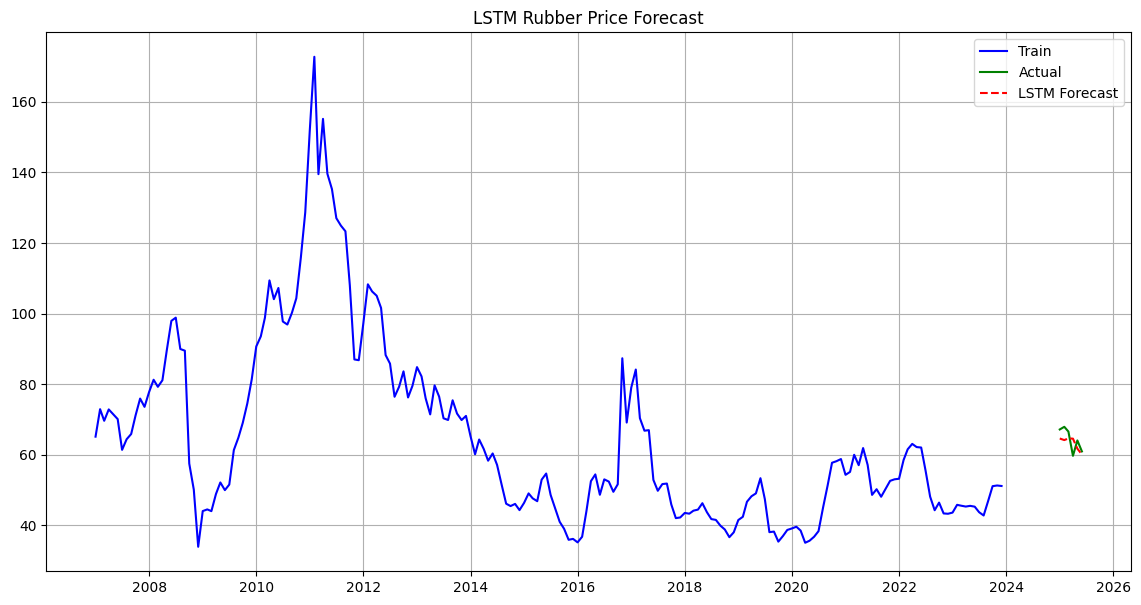

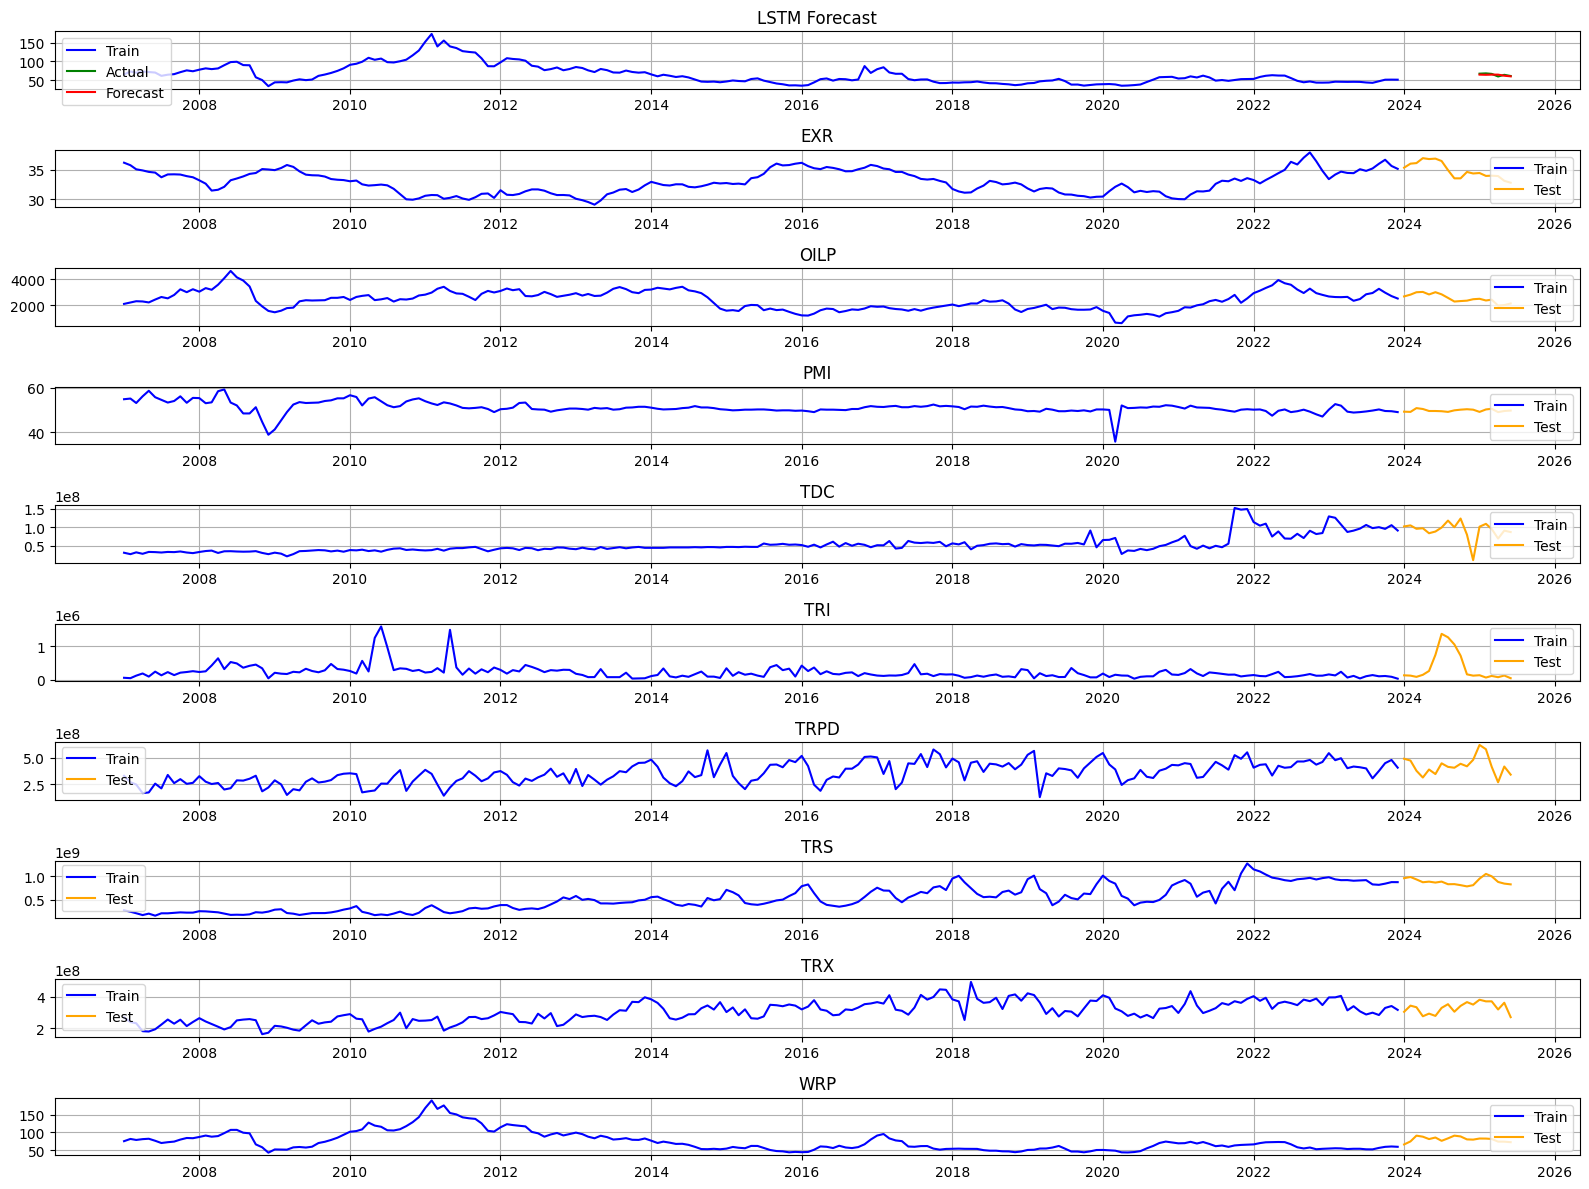

In [162]:
plt.figure(figsize=(14,7))
plt.plot(train_data.index, train_data['TRP'], label='Train', color='blue')
plt.plot(test_data.index[WINDOW:], actual_after, label='Actual', color='green')
plt.plot(test_data.index[WINDOW:], pred_after, label='LSTM Forecast', color='red', linestyle='--')
plt.title("LSTM Rubber Price Forecast")
plt.grid(True)
plt.legend()
plt.show()

fig, axes = plt.subplots(len(external_factors)+1, 1, figsize=(16,12))


axes[0].plot(train_data.index, train_data['TRP'], label='Train', color='blue')
axes[0].plot(test_data.index[WINDOW:], actual_after, color='green', label='Actual')
axes[0].plot(test_data.index[WINDOW:], pred_after, color='red', label='Forecast')
axes[0].legend()
axes[0].set_title("LSTM Forecast")
axes[0].grid(True)

for i, fac in enumerate(external_factors):
    ax = axes[i+1]
    ax.plot(train_data.index, train_data[fac], color='blue', label='Train')
    ax.plot(test_data.index, test_data[fac], color='orange', label='Test')
    ax.set_title(fac)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


In [125]:
def compute_score(rmse, mape, mean_trp, w_rmse=0.5, w_mape=0.5):
    """
    Unified Score 0–100 จาก RMSE และ MAPE
    """
    nrmse = rmse / mean_trp        # Normalize ด้วย mean ของ TRP
    mape_norm = mape / 100.0
    score = 100 * (1 - (w_rmse*nrmse + w_mape*mape_norm))
    return max(0, min(100, score))

score_before = compute_score(rmse_before, mape_before, mean_trp)
score_after  = compute_score(rmse_after,  mape_after,  mean_trp)

summary_df = pd.DataFrame({
    "Model": ["Before (Baseline Ridge)", "After (Optuna Ridge)"],
    "RMSE": [rmse_before, rmse_after],
    "MAPE (%)": [mape_before, mape_after],
    "Score (0-100)": [score_before, score_after]
})

print("=== COMPARISON: BEFORE vs AFTER (LSTM) ===")
print(summary_df.to_string(index=False))


=== COMPARISON: BEFORE vs AFTER (LSTM) ===
                  Model      RMSE  MAPE (%)  Score (0-100)
Before (Baseline Ridge) 13.654219 20.930290      78.962787
   After (Optuna Ridge)  3.007291  4.242517      95.550283


PCA + LSTM

In [126]:
print("\nPCA + LSTM")

approach_pca_lstm = []

scaler2 = StandardScaler()
train_scaled2 = scaler2.fit_transform(train_exog)
test_scaled2  = scaler2.transform(test_exog)

def seq_lstm(data, win=12):
    X, y = [], []
    for i in range(len(data)-win):
        X.append(data[i:i+win,:])
        y.append(data[i+win,0])
    return np.array(X), np.array(y)


for n_comp in range(2,10):

    pca = PCA(n_components=n_comp)
    train_pca = pca.fit_transform(train_scaled2)
    test_pca  = pca.transform(test_scaled2)

    explained = pca.explained_variance_ratio_.sum()

    #full matrix TRP + PCs
    train_full = np.concatenate([train_data[['TRP']].values, train_pca], axis=1)
    test_full  = np.concatenate([test_data[['TRP']].values, test_pca], axis=1)

    Xtr, ytr = seq_lstm(train_full)
    Xte, yte = seq_lstm(test_full)

    mdl = Sequential([
        LSTM(64, activation='tanh', return_sequences=False,
             input_shape=(12, train_full.shape[1])),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    mdl.compile(optimizer='adam', loss='mse')

    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    mdl.fit(
        Xtr, ytr,
        validation_split=0.1,
        epochs=100,
        batch_size=16,
        callbacks=[es],
        verbose=0
    )

    pred_unscaled = mdl.predict(Xte, verbose=0)

    # The model predicts unscaled TRP values, so no inverse transformation is needed.
    pred = pred_unscaled[:,0]

    rmse = np.sqrt(mean_squared_error(yte, pred))
    mape = mean_absolute_percentage_error(yte, pred)*100

    print(f"{n_comp} comp | Var={explained*100:.1f}% | RMSE={rmse:.4f} | MAPE={mape:.2f}%")

    approach_pca_lstm.append({
        "n_components": n_comp,
        "explained_var": explained,
        "RMSE": rmse,
        "MAPE": mape,
        "pred": pred,
        "true": yte
    })

best_pca_lstm = min(approach_pca_lstm, key=lambda x: x["RMSE"])

print("\n===== Best PCA+LSTM ====")
print("Components:", best_pca_lstm["n_components"])
print("Expl.Var :", best_pca_lstm["explained_var"]*100)
print("RMSE     :", best_pca_lstm["RMSE"])
print("MAPE     :", best_pca_lstm["MAPE"])


PCA + LSTM


c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2 comp | Var=59.2% | RMSE=4.8336 | MAPE=6.34%


c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3 comp | Var=70.4% | RMSE=15.1484 | MAPE=22.83%


c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4 comp | Var=79.5% | RMSE=5.1672 | MAPE=7.19%


c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5 comp | Var=88.2% | RMSE=18.3882 | MAPE=27.96%


c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6 comp | Var=92.8% | RMSE=15.4981 | MAPE=23.39%


c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7 comp | Var=96.2% | RMSE=14.6471 | MAPE=22.03%


c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8 comp | Var=98.5% | RMSE=19.1729 | MAPE=29.21%


c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9 comp | Var=100.0% | RMSE=13.8730 | MAPE=20.80%

===== Best PCA+LSTM ====
Components: 2
Expl.Var : 59.211034919261394
RMSE     : 4.833583821529942
MAPE     : 6.335256593206571


Data Visualization

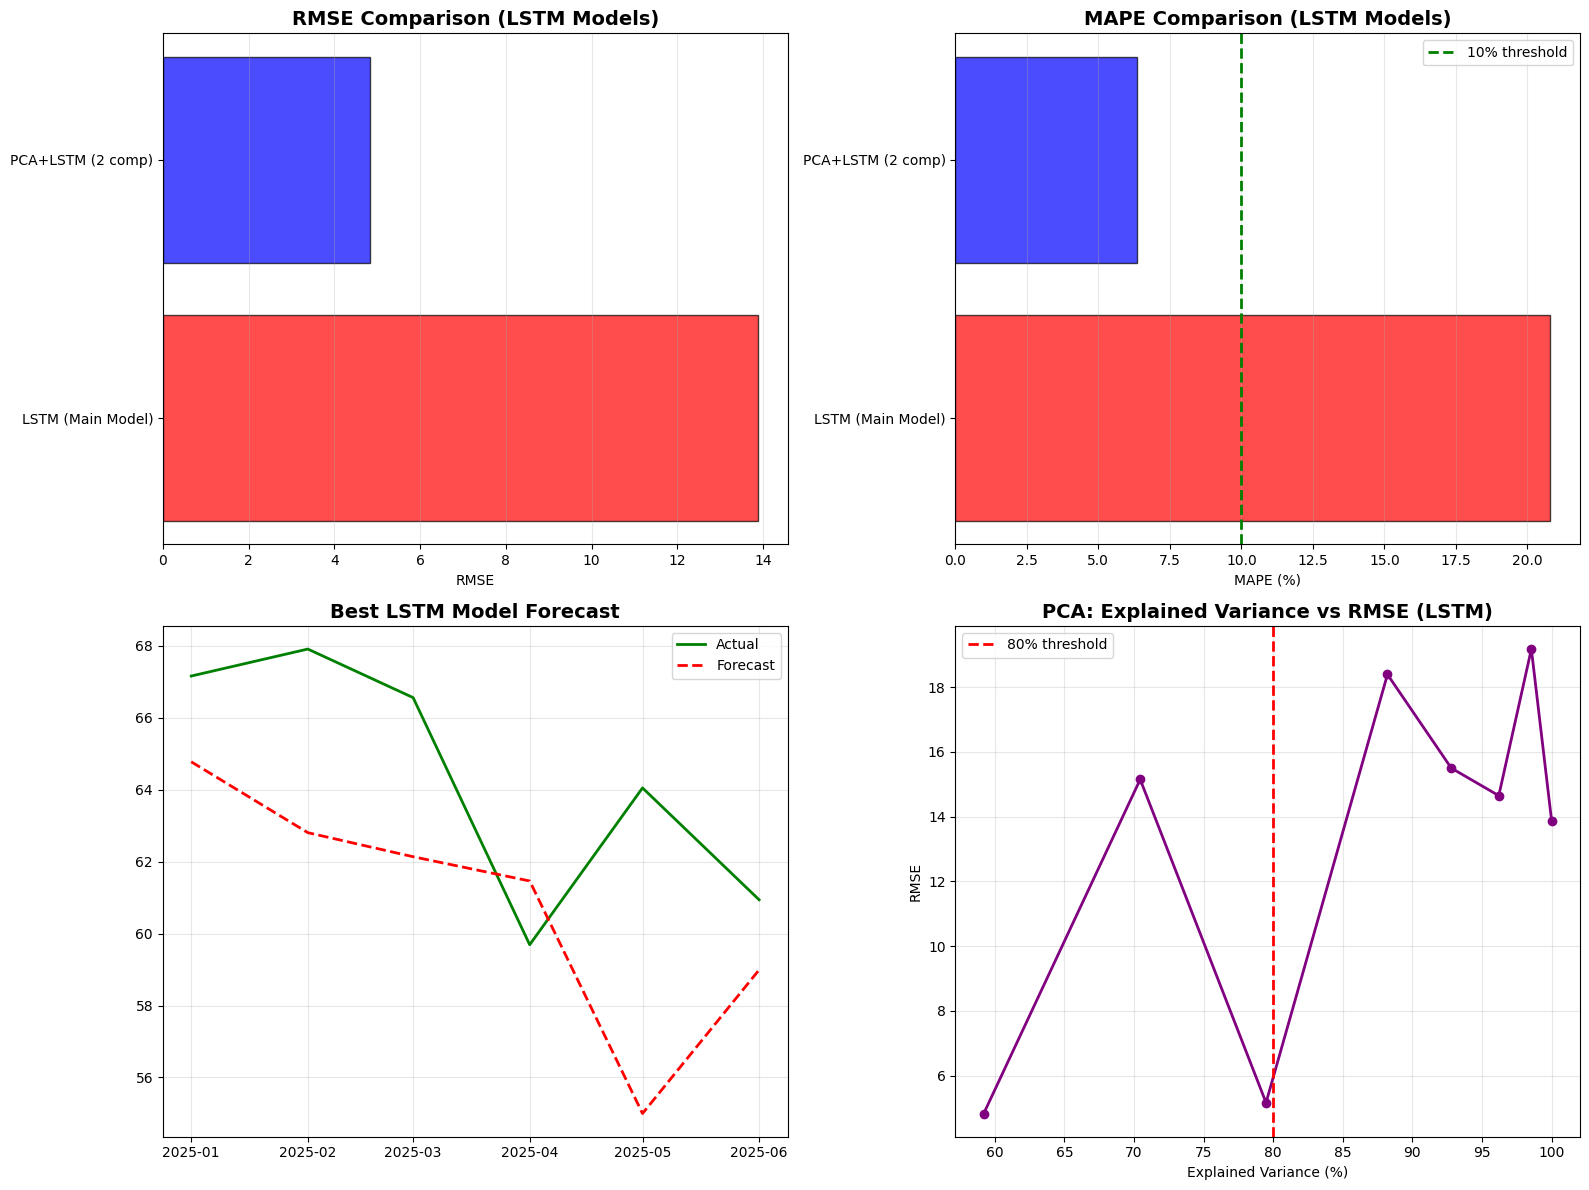

In [127]:
import matplotlib.pyplot as plt

#เทียบเฉพาะ LSTM Main + PCA+LSTM
all_approaches = [
    {
        "Method": "LSTM (Main Model)",
        "RMSE": rmse,
        "MAPE": mape
    },
    {
        "Method": f"PCA+LSTM ({best_pca_lstm['n_components']} comp)",
        "RMSE": best_pca_lstm['RMSE'],
        "MAPE": best_pca_lstm['MAPE']
    }
]

methods = [a["Method"] for a in all_approaches]
rmse_vals = [a["RMSE"] for a in all_approaches]
mape_vals = [a["MAPE"] for a in all_approaches]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

#RMSE Comparison
ax = axes[0, 0]
ax.barh(methods, rmse_vals, color=['red', 'blue'], alpha=0.7, edgecolor='black')
ax.set_title("RMSE Comparison (LSTM Models)", fontsize=14, fontweight='bold')
ax.set_xlabel("RMSE")
ax.grid(True, axis='x', alpha=0.3)


#MAPE Comparison
ax = axes[0, 1]
ax.barh(methods, mape_vals, color=['red', 'blue'], alpha=0.7, edgecolor='black')
ax.axvline(x=10, color='green', linestyle='--', linewidth=2, label='10% threshold')
ax.set_title("MAPE Comparison (LSTM Models)", fontsize=14, fontweight='bold')
ax.set_xlabel("MAPE (%)")
ax.legend()
ax.grid(True, axis='x', alpha=0.3)

#Best Model Forecast
best_overall = (
    best_pca_lstm
    if best_pca_lstm["RMSE"] < rmse
    else {"pred": pred, "true": actual}
)

ax = axes[1, 0]
#กรณีเป็น PCA+LSTM
if "true" in best_overall:
    ax.plot(
        test_data.index[WINDOW:],
        best_overall["true"],
        label="Actual",
        color="green",
        linewidth=2
    )
    ax.plot(
        test_data.index[WINDOW:],
        best_overall["pred"],
        label="Forecast",
        color="red",
        linestyle="--",
        linewidth=2
    )
else:
    #ถ้าเป็น main LSTM
    ax.plot(
        test_data.index[WINDOW:], actual, label='Actual', color='green', linewidth=2)
    ax.plot(
        test_data.index[WINDOW:], pred, label='Forecast', color='red', linestyle='--', linewidth=2)

ax.set_title("Best LSTM Model Forecast", fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

#PCA vs RMSE Curve
ax = axes[1, 1]
exp_vars = [r['explained_var']*100 for r in approach_pca_lstm]
rmse_vals_pca = [r['RMSE'] for r in approach_pca_lstm]

ax.plot(exp_vars, rmse_vals_pca, marker='o', color='purple', linewidth=2)
ax.axvline(x=80, linestyle='--', color='red', linewidth=2, label='80% threshold')

ax.set_xlabel("Explained Variance (%)")
ax.set_ylabel("RMSE")
ax.set_title("PCA: Explained Variance vs RMSE (LSTM)", fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

In [128]:
data = {
    'Model': ['Baseline (LSTM)', 'Optuna LSTM'],
    'RMSE': [rmse_before, rmse_after],
    'MAPE': [mape_before/100, mape_after/100],
    'ACCURACY': [score_before/100, score_after/100]
}

df_comparison = pd.DataFrame(data)

df_comparison['MAPE (%)'] = (df_comparison['MAPE'] * 100).map('{:.2f}%'.format)
df_comparison['ACCURACY (%)'] = (df_comparison['ACCURACY'] * 100).map('{:.2f}%'.format)

df_display = df_comparison[['Model', 'RMSE', 'MAPE (%)', 'ACCURACY (%)']]

print("Performance Comparison (LSTM)\n")
print(df_display.to_string(index=True, col_space=15))

Performance Comparison (LSTM)

                           Model            RMSE        MAPE (%)    ACCURACY (%)
0                Baseline (LSTM)       13.654219          20.93%          78.96%
1                    Optuna LSTM        3.007291           4.24%          95.55%
